In [47]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-white')
# Import ML packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from yellowbrick.datasets import load_credit
from yellowbrick.datasets import load_hobbies
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as shc

In [48]:
# Read weather csv file
weather = pd.read_csv("pit_weather.csv")
# Select only 5 columns from the initial dataset
weather = weather[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN']]
# Calculate the average temperature of the day
weather['TAVG'] = weather[['TMAX', 'TMIN']].mean(axis=1)
# Show if there are any missing values
weather.info()
# However, we will not drop the NaN values now for the convenience of merging dataset
weather.isnull().sum(axis=0)
# Print the first 5 rows of the dataset
weather.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1095 non-null   object 
 1   AWND    1092 non-null   float64
 2   PRCP    1094 non-null   float64
 3   TMAX    1093 non-null   float64
 4   TMIN    1093 non-null   float64
 5   TAVG    1093 non-null   float64
dtypes: float64(5), object(1)
memory usage: 51.5+ KB


,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,2017-01-02,7.16,0.09,46.0,36.0,41.0
2,2017-01-03,6.93,0.76,50.0,42.0,46.0
3,2017-01-04,15.66,0.04,45.0,21.0,33.0
4,2017-01-05,8.72,0.06,23.0,18.0,20.5


In [49]:
ride = pd.DataFrame(data = None)
for i in range(7,8):
    for j in range(1,3):
        ride_1 = pd.read_csv("healthy-ride-rentals-201{}-q{}.csv".format(i, j))
        # drop the lines with NA
        ride_1 = ride_1.dropna(axis=0)
        # copy the column with date
        ride_1["tmp"] = ride_1["Starttime"]
        # starttime and stoptime delete the date
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: str(x).split(" ")[1])
        # convert starttime to minutes
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: str(x).split(" ")[1])
        # convert stoptime to minutes
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        # extract date to a new column and then merge with weather dataset
        ride_1["DATE"] = ride_1["tmp"].apply(lambda x: str(str(x).split("/")[2]).split(" ")[0] + "-" + str(x).split("/")[0]+ "-"  + str(x).split("/")[1])
        # adjust the format
        ride_1["DATE"] = pd.to_datetime(ride_1["DATE"]).apply(lambda x: str(x).split(" ")[0])
        # delete the temp column
        del ride_1["tmp"]

        # add each subdataset
        ride = pd.concat([ride, ride_1])
ride

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,DATE
0,25723960,508,510,70478,110,1043,S Millvale Ave & Centre Ave,1044,Zulema St & Coltart Ave,Subscriber,2017-01-01
1,25724207,593,600,70439,426,1014,Ridge Ave & Brighton Rd (CCAC),1012,North Shore Trail & Fort Duquesne Bridge,Customer,2017-01-01
2,25724297,621,646,70440,1498,1019,42nd St & Butler St,1012,North Shore Trail & Fort Duquesne Bridge,Subscriber,2017-01-01
3,25724391,663,690,70002,1581,1019,42nd St & Butler St,1013,Isabella St & Federal St (PNC Park),Customer,2017-01-01
4,25724479,703,729,70024,1563,1018,Butler St & Stanton Ave,1013,Isabella St & Federal St (PNC Park),Customer,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...
24308,33295197,1418,1438,70240,1212,1023,Liberty Ave & Baum Blvd,1028,Penn Ave & Putnam St (Bakery Square),Customer,2017-06-30
24309,33295206,1418,1436,70178,1030,1023,Liberty Ave & Baum Blvd,1028,Penn Ave & Putnam St (Bakery Square),Customer,2017-06-30
24310,33295257,1425,7,70490,1351,1010,10th St & Penn Ave (David L. Lawrence Conventi...,1019,42nd St & Butler St,Customer,2017-06-30
24311,33295318,1435,2,70019,424,1049,S 12th St & E Carson St,1045,S 27th St & Sidney St. (Southside Works),Customer,2017-06-30


In [50]:
# Merge ride dataframe with weather dataframe based on DATE
df_merged = pd.merge(ride, weather, on='DATE')
df_merged.info()
# Show how many rows have empty values
df_merged.isnull().sum(axis=0)
# Drop rows which contain NaN values
df_merged = df_merged.dropna()
# Drop not useful columns
df_merged = df_merged.drop(['Trip id', 'Bikeid','From station name', 'To station name'], axis=1)
# Convert Usertype from categorical to dummy variable 0(customer) and 1(subscriber)
df_merged['Usertype'] = df_merged['Usertype'].astype('category').cat.codes
# Show top 5 rows of the dataset
df_merged

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31537 entries, 0 to 31536
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Trip id            31537 non-null  int64  
 1   Starttime          31537 non-null  int64  
 2   Stoptime           31537 non-null  int64  
 3   Bikeid             31537 non-null  int64  
 4   Tripduration       31537 non-null  int64  
 5   From station id    31537 non-null  int64  
 6   From station name  31537 non-null  object 
 7   To station id      31537 non-null  int64  
 8   To station name    31537 non-null  object 
 9   Usertype           31537 non-null  object 
 10  DATE               31537 non-null  object 
 11  AWND               31537 non-null  float64
 12  PRCP               31537 non-null  float64
 13  TMAX               31537 non-null  float64
 14  TMIN               31537 non-null  float64
 15  TAVG               31537 non-null  float64
dtypes: float64(5), int64(7

,Starttime,Stoptime,Tripduration,From station id,To station id,Usertype,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,508,510,110,1043,1044,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,593,600,426,1014,1012,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
2,621,646,1498,1019,1012,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
3,663,690,1581,1019,1013,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
4,703,729,1563,1018,1013,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31532,1418,1438,1212,1023,1028,0,2017-06-30,9.40,0.15,84.0,66.0,75.0
31533,1418,1436,1030,1023,1028,0,2017-06-30,9.40,0.15,84.0,66.0,75.0
31534,1425,7,1351,1010,1019,0,2017-06-30,9.40,0.15,84.0,66.0,75.0
31535,1435,2,424,1049,1045,0,2017-06-30,9.40,0.15,84.0,66.0,75.0


In [51]:
'''
for i in df_merged.columns:
    if df_merged[i].dtype == 'float64':
        df_merged[i] = df_merged[i].astype('float16')
    if df_merged[i].dtype == 'int64':
        df_merged[i] = df_merged[i].astype('int8')
df_merged.info()
'''

"\nfor i in df_merged.columns:\n    if df_merged[i].dtype == 'float64':\n        df_merged[i] = df_merged[i].astype('float16')\n    if df_merged[i].dtype == 'int64':\n        df_merged[i] = df_merged[i].astype('int8')\ndf_merged.info()\n"

In [52]:
del df_merged["DATE"]

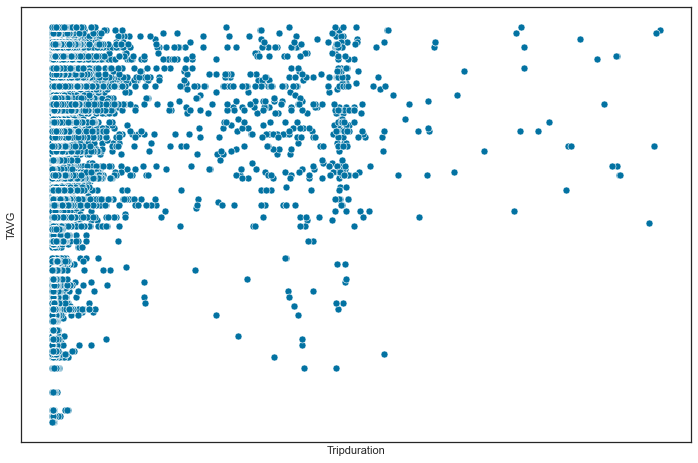

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.scatterplot(x='Tripduration',y='TAVG',data=df_merged, ax=ax);
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show();

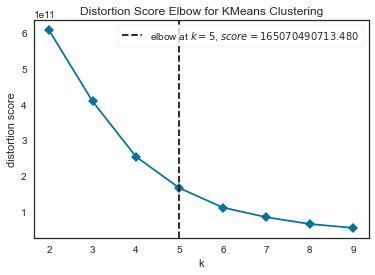

In [54]:
# create a KMeans object
model = KMeans(random_state=1)
# fit with data
model.fit(df_merged)

#run from k=2 to k=10
visualizer = KElbowVisualizer(model, k=(2,10), timings = False)
visualizer.fit(df_merged)
visualizer.show(); 

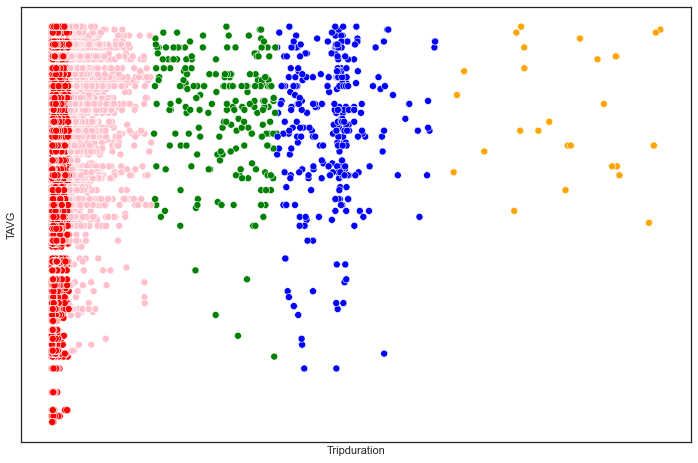

In [55]:
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan"])
# get the tuned model
model_tuned = KMeans(random_state=1, n_clusters=5).fit(df_merged)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.scatterplot(x='Tripduration',y='TAVG',data=df_merged, ax=ax, c=colors[model_tuned.labels_]);
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show();

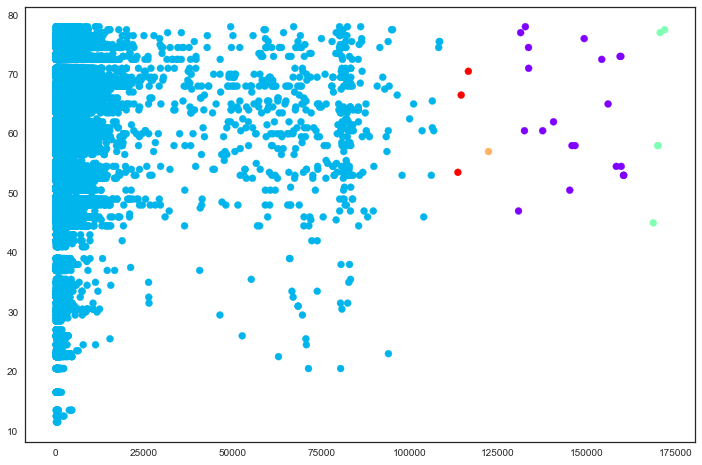

In [56]:
# about 30,000 rows
hc_single=AgglomerativeClustering(n_clusters=5,linkage='single').fit(df_merged)
plt.figure(figsize=(12, 8))
plt.scatter(x='Tripduration',y='TAVG',data=df_merged, c=hc_single.labels_, cmap='rainbow');
plt.show();

In [46]:
# about 220,000 rows
hc_single=AgglomerativeClustering(n_clusters=5,linkage='single').fit(df_merged)
plt.figure(figsize=(12, 8))
plt.scatter(x='Tripduration',y='TAVG',data=df_merged, c=hc_single.labels_, cmap='rainbow');
plt.show();

MemoryError: Unable to allocate 191. GiB for an array with shape (25640140926,) and data type float64